# Эксерименты с нормализацией и логарифмированием
В данном ноутбуке проводятся эксперименты с применением нормализации и логарифмирования. Для начала рассматривается baseline решение на чистых данных, затем поочередно применяются различные методы обработки данных.

In [41]:
import os
import sys
sys.path.insert(0, os.path.join('..'))
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

import radial as rd
from radial.batchflow import Dataset, FilesIndex, Pipeline, R, B, V, C
from radial.batchflow.models.tf import ResNet18
from radial.core import RadialBatch, concatenate_points

plt.style.use('ggplot')
%matplotlib inline

In [2]:
def draw_results(pipeline):
    point = np.array(pipeline.get_variable('points')).reshape(-1, 2, N_SAMPLES)
    target = np.array(pipeline.get_variable('targets'))
    predictions = np.array(pipeline.get_variable('predictions')).reshape(-1)
    
    
    print("MSE: %.3f" % mean_squared_error(target, predictions))

    _, ax = plt.subplots(3, 4, figsize=(20, 12))
    ax = ax.reshape(-1)
    s = 0
    for i in range(s, s+12):
        x = (point[i].T[:,0])
        y = (point[i].T[:,1])
        ax[i-s].scatter(x, y, c='b')
        ax[i-s].axhline(target[i], ls='--', c='g', lw=3, alpha=0.6, label='target')
        ax[i-s].axhline(predictions[i], ls='--', c='r', lw=3, alpha=0.6, label='predictions')
        ax[i-s].set_title('{}'.format(i))
        ax[i-s].legend()

In [3]:
N_SAMPLES = 50

# Baseline

In [7]:
ix = FilesIndex(path='./data/*')
dset = Dataset(ix, batch)
dset.split(0.7)

In [40]:
rad_data_ppl = (Pipeline()
                    .load(fmt='npz')
                    .drop_negative()
                    .drop_outliers()
                    .get_samples(N_SAMPLES, sampler=np.random.random)
)

rad_ppl = rad_data_ppl << dset.train

x = rad_ppl.next_batch(1, shuffle=True)

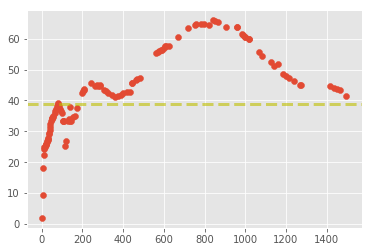

In [39]:
plt.scatter(x.time[0], x.derivative[0])
plt.axhline(x.target[0], ls='--', c='y', lw=3, alpha=0.6)
plt.show()

In [11]:
model_config = {
    'inputs': dict(points=dict(shape=(2, N_SAMPLES)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'body/num_blocks': [1, 1, 1],
    'body/filters': [8, 16, 32],
    'initial_block/filters': 4,
    'loss': 'mse',
    'optimizer': 'Adam'
}

In [12]:
train_pipeline = rad_data_ppl + (Pipeline()
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', ResNet18, 'point', config=model_config)
                  .train_model('point', fetches='loss', make_data=concatenate_points,
                               save_to=V('loss'), mode='a')
) << dset

test_pipeline = rad_data_ppl + (Pipeline()
                .init_variable('predictions', init_on_each_run=list)
                .init_variable('targets', init_on_each_run=list)
                .init_variable('points', init_on_each_run=list)
                .import_model('point', train_pipeline)
                .update_variable('targets', B('target'), mode='e')
                .predict_model('point', fetches=['predictions', 'points'],
                                make_data=concatenate_points,
                                save_to=[V('predictions'), V('points')], mode='a')
) << dset

In [24]:
train_pipeline.run(50, n_epochs=100, bar=True, drop_last=True)

100%|██████████| 1100/1100 [08:31<00:00,  2.58it/s]


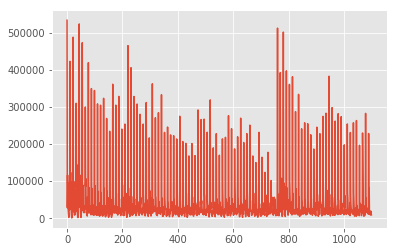

In [25]:
plt.plot(train_pipeline.get_variable('loss'))

MSE: 63488.020


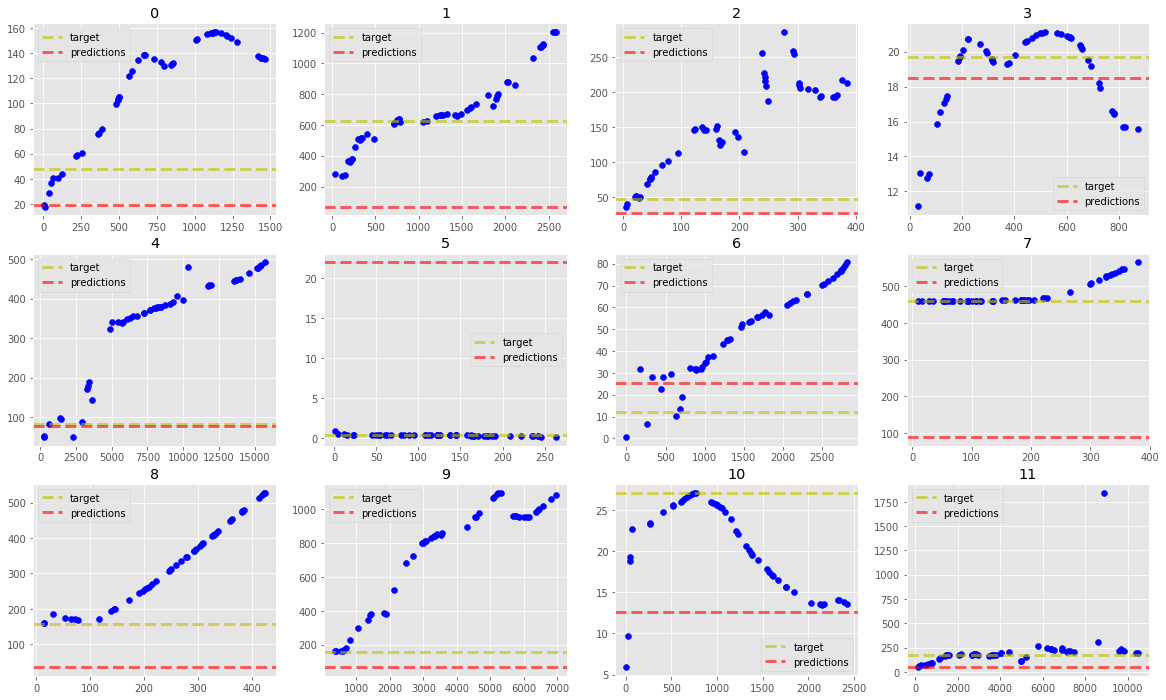

In [28]:
test_pipeline.run(50, n_epochs=1, drop_last=True)
draw_results(test_pipeline)

# Log_log data + log ans

In [15]:
def log(*args):
    return np.array(list(map(np.log10, args)))

In [11]:
log_log_ppl = (Pipeline()
                    .load(fmt='npz')
                    .drop_negative()
                    .drop_outliers()
                    .get_samples(N_SAMPLES, sampler=np.random.random)
                    .apply_transform(log, src=['time', 'derivative', 'target'], dst=['log_time', 'log_derivative', 'log_target'])
)

In [12]:
def concatenate_log_points(batch, model, return_targets=True):
    _ = model
    zip_data = zip(batch.log_time, batch.log_derivative)
    points = np.array(list(map(lambda d: np.array([d[0], d[1]])\
                .reshape(-1, batch.log_derivative[0].shape[1]), zip_data)))
    res_dict = {'feed_dict': {'points': points}}
    if return_targets:
        y = batch.log_target.reshape(-1, 1)
        res_dict['feed_dict']['targets'] = y
    return res_dict

In [17]:
log_tr_ppl = log_log_ppl + (Pipeline()
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', ResNet18, 'log_point', config=model_config)
                  .train_model('log_point', fetches='loss', make_data=concatenate_log_points,
                               save_to=V('loss'), mode='a')
) << dset.train

In [18]:
log_tr_ppl.run(50, n_epochs=100, bar=True, drop_last=True)

100%|█████████▉| 999/1000 [07:31<00:00,  2.45it/s]


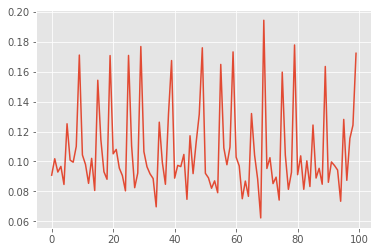

In [29]:
plt.plot(log_tr_ppl.get_variable('loss')[-100:])

In [26]:
log_te_ppl = log_log_ppl + (Pipeline()
                .init_variable('predictions', init_on_each_run=list)
                .init_variable('targets', init_on_each_run=list)
                .init_variable('points', init_on_each_run=list)
                .import_model('log_point', log_tr_ppl)
                .update_variable('targets', B('log_target'), mode='e')
                .predict_model('log_point', fetches=['predictions', 'points'],
                                make_data=concatenate_log_points,
                                save_to=[V('predictions'), V('points')], mode='a')
) << dset.test

MSE: 645.359
MSE: 0.118


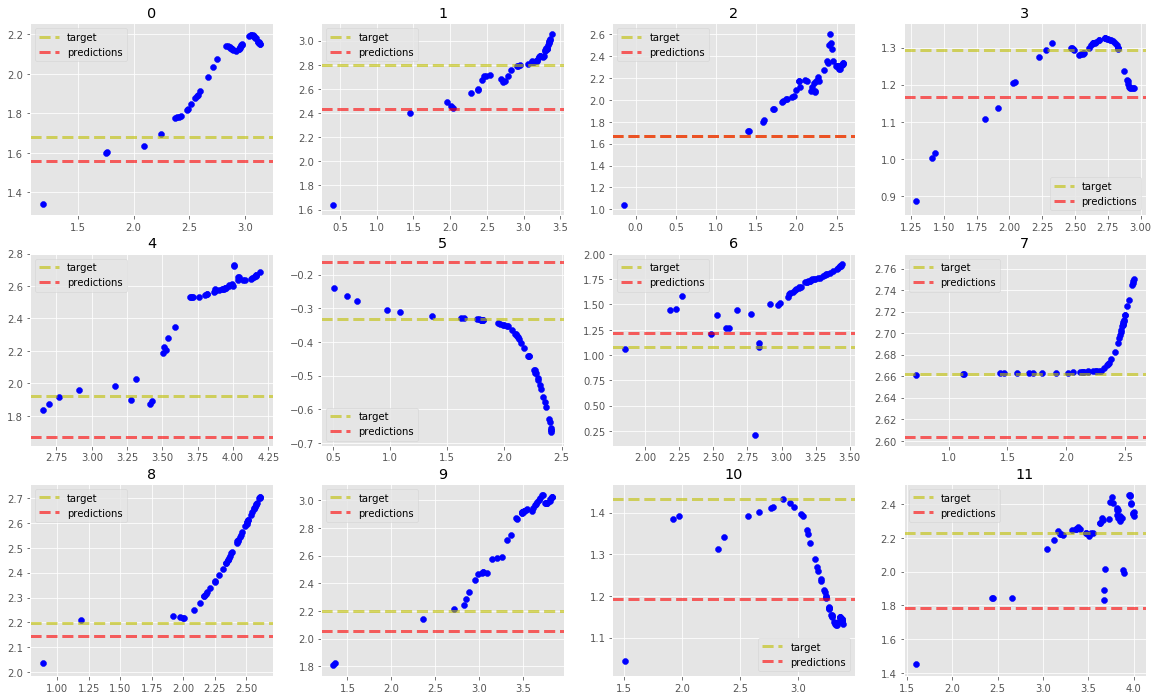

In [28]:
log_te_ppl.run(50, n_epochs=1, drop_last=True)
point = np.array(log_te_ppl.get_variable('points')).reshape(-1, 2, N_SAMPLES)
target = 10**np.array(log_te_ppl.get_variable('targets'))
predictions = 10**np.array(log_te_ppl.get_variable('predictions')).reshape(-1)
print("MSE: %.3f" % np.sqrt(mean_squared_error(target, predictions)))

draw_results(log_te_ppl)

# Log-log data + ans

In [75]:
ans_ppl = (Pipeline()
                    .load(fmt='npz')
                    .drop_negative()
                    .drop_outliers()
                    .get_samples(N_SAMPLES, sampler=np.random.random)
                    .apply_transform(log, src=['time', 'derivative'], dst=['log_time', 'log_derivative'])
)

In [13]:
import tensorflow as tf
def predictions(tensor):
    return tf.math.pow(tf.constant(10.), tensor)
model_config['predictions'] = predictions

In [14]:
def concatenate_ans_points(batch, model, return_targets=True):
    _ = model
    zip_data = zip(batch.log_time, batch.log_derivative)
    points = np.array(list(map(lambda d: np.array([d[0], d[1]])\
                .reshape(-1, batch.log_derivative[0].shape[1]), zip_data)))
    res_dict = {'feed_dict': {'points': points}}
    if return_targets:
        y = batch.target.reshape(-1, 1)
        res_dict['feed_dict']['targets'] = y
    return res_dict

In [79]:
ans_tr_ppl = ans_ppl + (Pipeline()
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', ResNet18, 'ans_point', config=model_config)
                  .train_model('ans_point', fetches='loss', make_data=concatenate_log_points,
                               save_to=V('loss'), mode='a')
) << dset

ans_te_ppl = ans_ppl + (Pipeline()
                .init_variable('predictions', init_on_each_run=list)
                .init_variable('targets', init_on_each_run=list)
                .init_variable('points', init_on_each_run=list)
                .import_model('log_point', train_pipeline)
                .update_variable('targets', B('target'), mode='e')
                .predict_model('log_point', fetches=['predictions', 'points'],
                                make_data=concatenate_ans_points,
                                save_to=[V('predictions'), V('points')], mode='a')
) << dset

In [80]:
ans_tr_ppl.run(50, n_epochs=1, bar=True, drop_last=True)



  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:05<00:22,  2.53s/it]

 27%|██▋       | 3/11 [00:05<00:15,  1.93s/it]

 36%|███▋      | 4/11 [00:06<00:10,  1.49s/it]

 45%|████▌     | 5/11 [00:06<00:07,  1.18s/it]

 55%|█████▍    | 6/11 [00:06<00:04,  1.05it/s]

 64%|██████▎   | 7/11 [00:07<00:03,  1.25it/s]

 73%|███████▎  | 8/11 [00:07<00:02,  1.46it/s]

 82%|████████▏ | 9/11 [00:08<00:01,  1.66it/s]

 91%|█████████ | 10/11 [00:08<00:00,  1.89it/s]

100%|██████████| 11/11 [00:09<00:00,  1.97it/s]



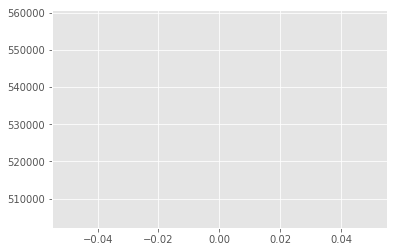

In [82]:
plt.plot(ans_tr_ppl.get_variable('loss'))

# norm data

In [10]:
norm_ppl = (Pipeline()
            .load(fmt='npz')
            .drop_negative()
            .drop_outliers()
            .get_samples(N_SAMPLES, sampler=np.random.random)
            .normalize_component(src=['time', 'derivative', 'target'],
                                 dst=['norm_time', 'norm_derivative', 'norm_target'],
                                 range_src=[None, None, 'derivative_q'],
                                 range_dst=[None, 'derivative_q', None])
)

In [14]:
def concatenate_norm_points(batch, model, return_targets=True):
    _ = model
    zip_data = zip(batch.norm_time, batch.norm_derivative)
    points = np.array(list(map(lambda d: np.array([d[0], d[1]])\
                .reshape(-1, batch.norm_derivative[0].shape[1]), zip_data)))
    res_dict = {'feed_dict': {'points': points}}
    if return_targets:
        y = batch.norm_target.reshape(-1, 1)
        res_dict['feed_dict']['targets'] = y
    return res_dict

In [52]:
log_tr_ppl = norm_ppl + (Pipeline()
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', ResNet18, 'norm_point', config=model_config)
                  .train_model('norm_point', fetches='loss', make_data=concatenate_norm_points,
                               save_to=V('loss'), mode='a')
) << dset.train

log_te_ppl = norm_ppl + (Pipeline()
                .init_variable('predictions', init_on_each_run=list)
                .init_variable('targets', init_on_each_run=list)
                .init_variable('points', init_on_each_run=list)
                .init_variable('bar', init_on_each_run=list)
                .import_model('norm_point', log_tr_ppl)
                .update_variable('targets', B('norm_target'), mode='e')
                .predict_model('norm_point', fetches=['predictions', 'points'],
                                make_data=concatenate_log_points,
                                save_to=[V('predictions'), V('points')], mode='a')
) << dset.test

In [35]:
log_tr_ppl.run(50, n_epochs=100, bar=True, drop_last=True)

100%|█████████▉| 999/1000 [07:38<00:00,  2.56it/s]


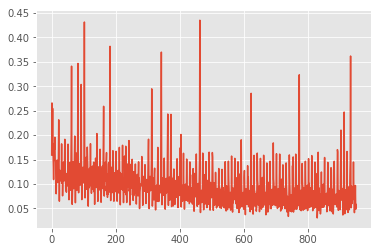

In [50]:
plt.plot(log_tr_ppl.get_variable('loss')[-950:])

MSE: 0.079


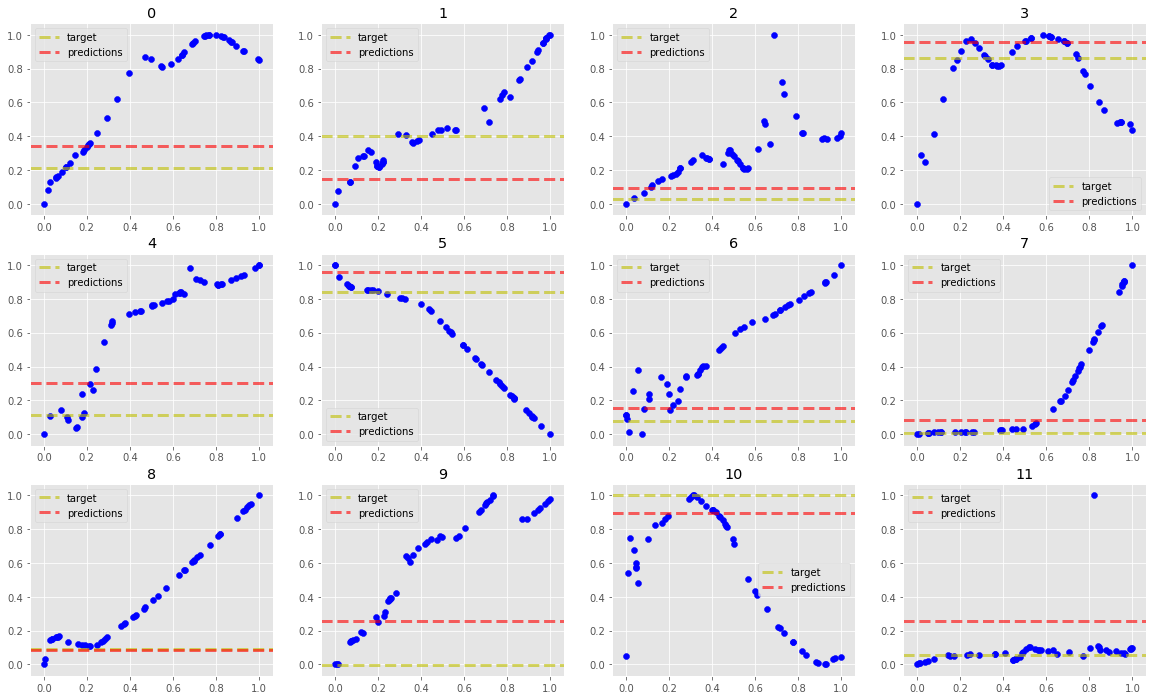

In [38]:
log_te_ppl.run(50, n_epochs=1, drop_last=True)
draw_results(log_te_ppl)

# norm_log data

In [16]:
norm_log_ppl = (Pipeline()
            .load(fmt='npz')
            .drop_negative()
#             .drop_outliers()
            .apply_transform(log, src=['time', 'derivative', 'target'], dst=['log_time', 'log_derivative', 'log_target'])
            .normalize_component(src=['log_time', 'log_derivative', 'log_target'],
                                 dst=['norm_time', 'norm_derivative', 'norm_target'],
                                 range_src=[None, None, 'derivative_q'],
                                 range_dst=[None, 'derivative_q', None])
            .get_samples(N_SAMPLES, sampler=np.random.random)
)

In [17]:
norm_log_ppl_big = norm_log_ppl << dset.train
x = norm_log_ppl_big.run(30,n_epochs=1, shuffle=False, bar=True)

 92%|█████████▏| 12/13 [00:00<00:00, 13.30it/s]


In [18]:
norm_log_tr_ppl = norm_log_ppl + (Pipeline()
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', ResNet18, 'norm_point', config=model_config)
                  .train_model('norm_point', fetches='loss', make_data=concatenate_norm_points,
                               save_to=V('loss'), mode='a')
) << dset.train

norm_log_te_ppl = norm_log_ppl + (Pipeline()
                .init_variable('predictions', init_on_each_run=list)
                .init_variable('targets', init_on_each_run=list)
                .init_variable('points', init_on_each_run=list)
                .init_variable('bar', init_on_each_run=list)
                .import_model('norm_point', norm_log_tr_ppl)
                .update_variable('targets', B('norm_target'), mode='e')
                .predict_model('norm_point', fetches=['predictions', 'points'],
                                make_data=concatenate_norm_points,
                                save_to=[V('predictions'), V('points')], mode='a')
) << dset.test

In [19]:
norm_log_tr_ppl.run(50, n_epochs=100, bar=True, drop_last=True)

100%|██████████| 700/700 [01:44<00:00,  7.23it/s]


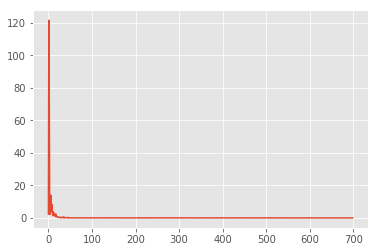

In [20]:
plt.plot(norm_log_tr_ppl.get_variable('loss'))#[-980:])
plt.show()

In [21]:
norm_log_te_ppl = norm_log_ppl + (Pipeline()
                .init_variable('predictions', init_on_each_run=list)
                .init_variable('targets', init_on_each_run=list)
                .init_variable('points', init_on_each_run=list)
                .import_model('norm_point', norm_log_tr_ppl)
                .update_variable('targets', B('norm_target'), mode='e')
                .predict_model('norm_point', fetches=['predictions', 'points'],
                                make_data=concatenate_norm_points,
                                save_to=[V('predictions'), V('points')], mode='a')
) << dset.test

In [22]:
norm_log_te_ppl.run(50, n_epochs=1, drop_last=True)

MSE: 0.038


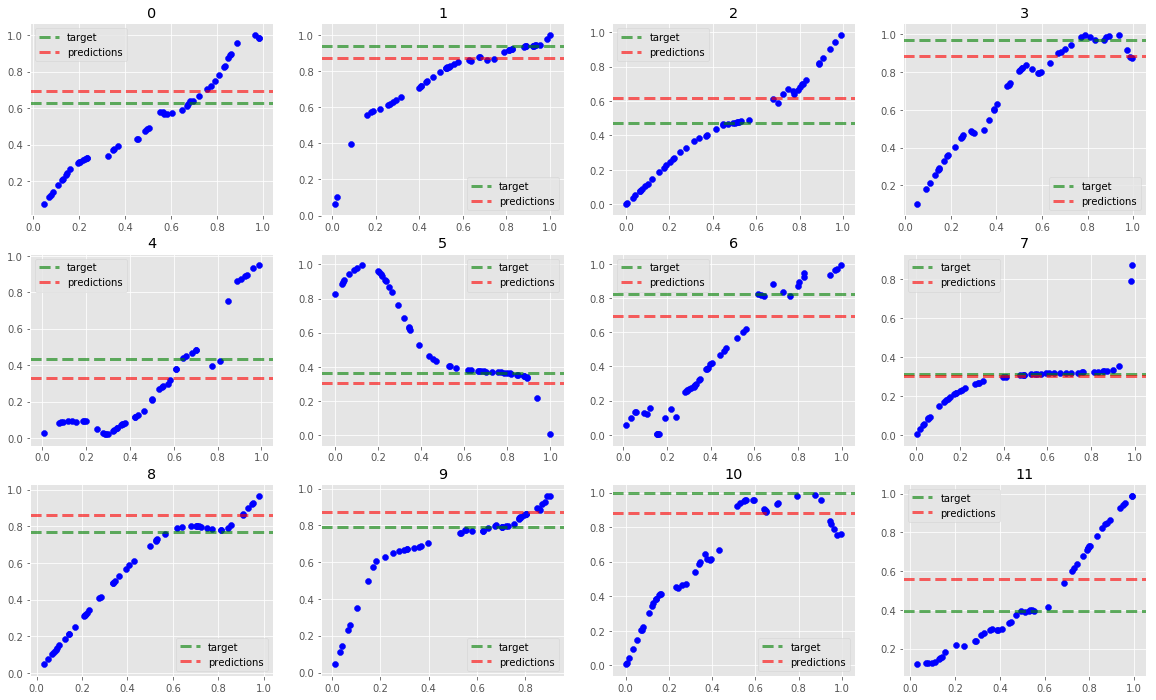

In [23]:
norm_log_te_ppl.run(50, n_epochs=1, drop_last=True)
draw_results(norm_log_te_ppl)

# Метрики
Посчитаем среднее абсолютное отклонение

In [25]:
from sklearn.metrics import mean_absolute_error as mae
mae(target, predictions)

0.1492047384643059

Нарисуем гистограмму разницы между предсказанием и ответом

(array([45., 47., 24., 15.,  8.,  6.,  3.,  1.,  0.,  1.]),
 array([0.00247091, 0.07661252, 0.15075413, 0.22489574, 0.29903735,
        0.37317897, 0.44732058, 0.52146219, 0.5956038 , 0.66974541,
        0.74388703]),
 <a list of 10 Patch objects>)

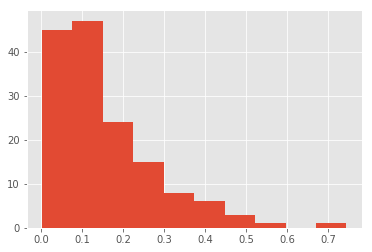

In [26]:
plt.hist(np.abs(predictions - target))

Теперь посмотрим примеры, на которых мы ошибаемся сильнее всего

In [43]:
point = np.array(norm_log_te_ppl.get_variable('points')).reshape(-1, 2, N_SAMPLES)
target = np.array(norm_log_te_ppl.get_variable('targets'))
predictions = np.array(norm_log_te_ppl.get_variable('predictions')).reshape(-1)
ix = np.argsort((predictions - target)**2/len(target))

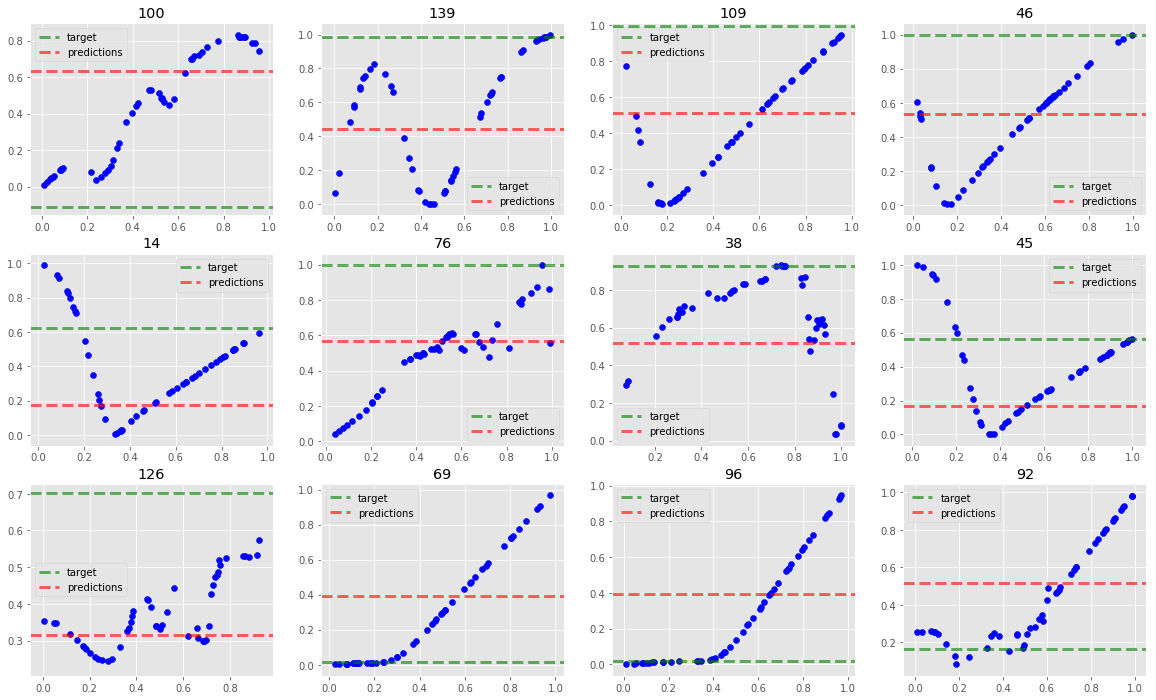

In [27]:
_, ax = plt.subplots(3, 4, figsize=(20, 12))
ax = ax.reshape(-1)
s = 0
q = 0
for i in ix[::-1][:12]:
    x = (point[i].T[:,0])
    y = (point[i].T[:,1])
    ax[q].scatter(x, y, c='b')
    ax[q].axhline(target[i], ls='--', c='g', lw=3, alpha=0.6, label='target')
    ax[q].axhline(predictions[i], ls='--', c='r', lw=3, alpha=0.6, label='predictions')
    ax[q].set_title('{}'.format(i))
    ax[q].legend()
    q+=1

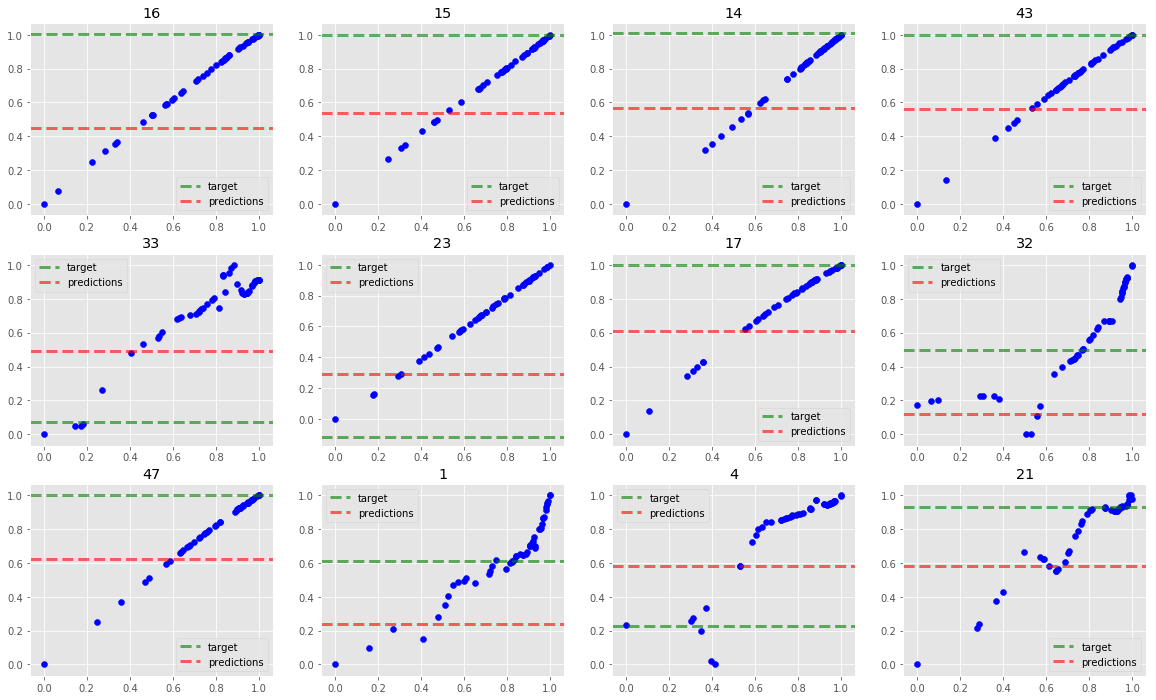

In [118]:
_, ax = plt.subplots(3, 4, figsize=(20, 12))
ax = ax.reshape(-1)
s = 0
q = 0
for i in ix[::-1][:12]:
    x = (point[i].T[:,0])
    y = (point[i].T[:,1])
    ax[q].scatter(x, y, c='b')
    ax[q].axhline(target[i], ls='--', c='g', lw=3, alpha=0.6, label='target')
    ax[q].axhline(predictions[i], ls='--', c='r', lw=3, alpha=0.6, label='predictions')
    ax[q].set_title('{}'.format(i))
    ax[q].legend()
    q+=1